Importando as bibliotecas

In [1]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats import kstest, norm

Importando os dados

In [2]:
diretorio_principal = os.getcwd()
subdiretorio_dados = os.path.join(diretorio_principal, "Dados")

# Criar o diretório se não existir
os.makedirs(subdiretorio_dados, exist_ok=True)

In [3]:
anos = range(2008, 2024)
formato = "csv"
url_base = "http://www.camara.leg.br/cotas/"

for ano in anos:
    download = requests.get(url_base + f"Ano-{ano}.{formato}.zip")
    caminho_zip = os.path.join(subdiretorio_dados, f"Ano-{ano}.{formato}.zip")

    with open(caminho_zip, "wb") as file:
        file.write(download.content)

    # Extrair o conteúdo do arquivo ZIP
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        zip_ref.extractall(subdiretorio_dados)

    # # Remover o arquivo ZIP após extração (opcional)
    # os.remove(caminho_zip)

In [5]:
# Voltar ao diretório principal
os.chdir(diretorio_principal)

# Criar um DataFrame com os dados extraídos
despesas_totais = []

for arquivo_csv in os.listdir(subdiretorio_dados):
    if arquivo_csv.endswith('.csv') and not arquivo_csv.startswith("."):
        caminho_csv = os.path.join(subdiretorio_dados, arquivo_csv)
        despesas = pd.read_csv(caminho_csv, sep=";", encoding='UTF-8', low_memory=False)
        despesas_totais.append(despesas)

# Concatenar todos os DataFrames em um único DataFrame
despesas_completo = pd.concat(despesas_totais, ignore_index=True)

In [7]:
despesas_completo

,txNomeParlamentar,cpf,ideCadastro,nuCarteiraParlamentar,nuLegislatura,sgUF,sgPartido,codLegislatura,numSubCota,txtDescricao,...,numParcela,txtPassageiro,txtTrecho,numLote,numRessarcimento,datPagamentoRestituicao,vlrRestituicao,nuDeputadoId,ideDocumento,urlDocumento
0,LIDERANÇA DO PSDB,NaN,NaN,NaN,2011,NaN,NaN,54,1,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,...,0,NaN,NaN,588705,NaN,NaN,NaN,2442,2246504,NaN
1,LIDERANÇA DO PSDB,NaN,NaN,NaN,2011,NaN,NaN,54,1,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,...,0,NaN,NaN,588705,NaN,NaN,NaN,2442,2246505,NaN
2,LIDERANÇA DO PSDB,NaN,NaN,NaN,2011,NaN,NaN,54,1,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,...,0,NaN,NaN,568174,NaN,NaN,NaN,2442,2181555,NaN
3,LIDERANÇA DO PSDB,NaN,NaN,NaN,2011,NaN,NaN,54,1,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,...,0,NaN,NaN,574051,NaN,NaN,NaN,2442,2193013,NaN
4,LIDERANÇA DO PSDB,NaN,NaN,NaN,2011,NaN,NaN,54,3,COMBUSTÍVEIS E LUBRIFICANTES.,...,0,NaN,NaN,561555,NaN,NaN,NaN,2442,2150852,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4666973,EDIGAR MÃO BRANCA,1.222867e+10,143253.0,534.0,2007,BA,PV,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,1976,0,NaN
4666974,CHICO ABREU,1.477453e+10,146308.0,537.0,2007,GO,PR,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,1978,0,NaN
4666975,MARCELO ALMEIDA,5.980260e+10,146613.0,631.0,2007,PR,PMDB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,1979,0,NaN
4666976,MAJOR FÁBIO,4.801863e+10,149327.0,599.0,2007,PB,DEM,53,7,AQUISIÇÃO OU LOC. DE SOFTWARE; SERV. POSTAIS; ...,...,0,NaN,NaN,427520,NaN,NaN,NaN,1986,1687411,NaN


Selecionando colunas de interesse

In [8]:
# Listar colunas
despesas_completo.columns

Index(['txNomeParlamentar', 'cpf', 'ideCadastro', 'nuCarteiraParlamentar',
       'nuLegislatura', 'sgUF', 'sgPartido', 'codLegislatura', 'numSubCota',
       'txtDescricao', 'numEspecificacaoSubCota', 'txtDescricaoEspecificacao',
       'txtFornecedor', 'txtCNPJCPF', 'txtNumero', 'indTipoDocumento',
       'datEmissao', 'vlrDocumento', 'vlrGlosa', 'vlrLiquido', 'numMes',
       'numAno', 'numParcela', 'txtPassageiro', 'txtTrecho', 'numLote',
       'numRessarcimento', 'datPagamentoRestituicao', 'vlrRestituicao',
       'nuDeputadoId', 'ideDocumento', 'urlDocumento'],
      dtype='object')

In [9]:
#Total de parlamentares por partido

# Group by 'sgPartido' e conta quantas vezes aparece 'txNomeParlamentar' em cada partido
part_total = despesas_completo.groupby('sgPartido')['txNomeParlamentar'].count()

print(part_total)

sgPartido
AVANTE            27745
CIDADANIA         11803
DEM              247692
MDB              230520
NOVO              10194
PATRI             14820
PATRIOTA           7620
PCdoB            111592
PDT              167526
PEN                 729
PHS               12062
PL               164742
PMDB             313274
PMN                8115
PODE              72608
PP               273137
PP**             173469
PPL                2227
PPS               72946
PR               252306
PRB               75917
PRD                2157
PROS              78855
PRP                4039
PRTB                268
PSB              242792
PSC               88254
PSD              301343
PSDB             407567
PSDC                236
PSL               18121
PSOL              45958
PT               716036
PTB              114643
PTC                3743
PTdoB             10662
PV                71924
REDE               8609
REPUBLICANOS      86033
S.PART.            6241
SDD               55193
SOLIDA

In [10]:
#Somando o 'vlrLiquido' por partido 

# Group by 'sgPartido' e soma o valor contido em 'vlrLiquido' por partido
vlrLiquido_por_partido = despesas_completo.groupby('sgPartido')['vlrLiquido'].sum()

print(vlrLiquido_por_partido)



sgPartido
AVANTE           2.117583e+07
CIDADANIA        8.512710e+06
DEM              1.381063e+08
MDB              1.731049e+08
NOVO             3.911601e+06
PATRI            8.224330e+06
PATRIOTA         8.258312e+06
PCdoB            6.811278e+07
PDT              1.121330e+08
PEN              2.709355e+05
PHS              8.693070e+06
PL               1.560350e+08
PMDB             1.518192e+08
PMN              4.944567e+06
PODE             4.991398e+07
PP               2.053843e+08
PP**             7.666370e+07
PPL              1.871244e+06
PPS              3.188869e+07
PR               1.355463e+08
PRB              5.676098e+07
PRD              2.242207e+06
PROS             5.338680e+07
PRP              3.889258e+06
PRTB             1.675898e+05
PSB              1.351641e+08
PSC              5.418096e+07
PSD              2.121930e+08
PSDB             2.128687e+08
PSDC             1.250884e+05
PSL              1.132201e+07
PSOL             2.919510e+07
PT               3.924551e+08


In [11]:
#vlrLiquido por quantidade de parlamentar por patido 

vlrLiquido_por_parlamentar_por_pat = vlrLiquido_por_partido / part_total

print(vlrLiquido_por_parlamentar_por_pat)

sgPartido
AVANTE            763.230349
CIDADANIA         721.232749
DEM               557.572896
MDB               750.932167
NOVO              383.715976
PATRI             554.948052
PATRIOTA         1083.767993
PCdoB             610.373287
PDT               669.346926
PEN               371.653594
PHS               720.698912
PL                947.147466
PMDB              484.621248
PMN               609.312042
PODE              687.444694
PP                751.946128
PP**              441.944646
PPL               840.253134
PPS               437.154794
PR                537.229647
PRB               747.671524
PRD              1039.502531
PROS              677.024921
PRP               962.926036
PRTB              625.335075
PSB               556.707391
PSC               613.920748
PSD               704.157774
PSDB              522.291322
PSDC              530.035763
PSL               624.800261
PSOL              635.256201
PT                548.094135
PTB               673.575451
PTC 

In [12]:
# Selecionar colunas
dataset = despesas_completo.loc[:,['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido' ]]

In [13]:
# Visualizar dados de estudo
dataset

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
0,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-12-26T00:00:00,8275.08
1,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-12-26T00:00:00,9432.00
2,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-09-27T00:00:00,5112.00
3,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-10-27T00:00:00,77.80
4,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-08-15T00:00:00,106.11
...,...,...,...,...,...
4666973,BA,PV,TELEFONIA,2008-12-01T00:00:00,196.92
4666974,GO,PR,TELEFONIA,2008-12-01T00:00:00,95.62
4666975,PR,PMDB,TELEFONIA,2008-12-01T00:00:00,81.53
4666976,PB,DEM,AQUISIÇÃO OU LOC. DE SOFTWARE; SERV. POSTAIS; ...,2008-12-23T00:00:00,51.10


In [14]:
# Listar colunas
dataset.columns

Index(['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido'], dtype='object')

Conferindo dados Selecionados

In [15]:
dataset.head(10)

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
0,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-12-26T00:00:00,8275.08
1,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-12-26T00:00:00,9432.00
2,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-09-27T00:00:00,5112.00
3,NaN,NaN,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,2011-10-27T00:00:00,77.80
4,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-08-15T00:00:00,106.11
5,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-08-29T00:00:00,80.00
6,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-10-04T00:00:00,20.00
7,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-09-02T00:00:00,50.00
8,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-10-18T00:00:00,50.00
9,NaN,NaN,COMBUSTÍVEIS E LUBRIFICANTES.,2011-08-12T00:00:00,113.59


In [16]:
dataset.tail(10)

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
4666968,SP,PTdoB,TELEFONIA,2008-12-01T00:00:00,477.64
4666969,PB,PMDB,TELEFONIA,2008-03-10T00:00:00,44.18
4666970,PB,PMDB,TELEFONIA,2008-12-01T00:00:00,749.87
4666971,ES,PMDB,TELEFONIA,2008-12-01T00:00:00,349.22
4666972,RS,PP**,TELEFONIA,2008-12-01T00:00:00,306.34
4666973,BA,PV,TELEFONIA,2008-12-01T00:00:00,196.92
4666974,GO,PR,TELEFONIA,2008-12-01T00:00:00,95.62
4666975,PR,PMDB,TELEFONIA,2008-12-01T00:00:00,81.53
4666976,PB,DEM,AQUISIÇÃO OU LOC. DE SOFTWARE; SERV. POSTAIS; ...,2008-12-23T00:00:00,51.10
4666977,DF,PR,COMBUSTÍVEIS E LUBRIFICANTES.,2008-10-05T00:00:00,22.40


In [17]:
dataset.shape

(4666978, 5)

In [18]:
dataset['vlrLiquido'].describe()

count    4.666978e+06
mean     6.294329e+02
std      2.126989e+03
min     -2.097470e+04
25%      4.500000e+01
50%      1.444000e+02
75%      4.900000e+02
max      2.150000e+05
Name: vlrLiquido, dtype: float64

In [19]:
dataset[['sgUF', 'sgPartido', 'txtDescricao']].describe()

,sgUF,sgPartido,txtDescricao
count,4658823,4658823,4666978
unique,27,43,24
top,SP,PT,PASSAGEM AÉREA - RPA
freq,727099,716036,1029936


In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4666978 entries, 0 to 4666977
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sgUF          object 
 1   sgPartido     object 
 2   txtDescricao  object 
 3   datEmissao    object 
 4   vlrLiquido    float64
dtypes: float64(1), object(4)
memory usage: 178.0+ MB


Alterar tipos de dados

In [21]:
dataset['datEmissao'] = pd.to_datetime(dataset['datEmissao'], errors='coerce')

Limpeza de dados

In [22]:
#Remover duplicatas
dataset = dataset.drop_duplicates(keep="first")

In [23]:
#Remover valores
#dataset = dataset.loc[dataset['coluna'] == 'valor']

In [24]:
#Remover colunas desnecessárias
#dataset = dataset.drop(columns=['coluna1', 'coluna2'])

Dados faltantes

In [25]:
#Deletar linhas com dados faltantes
dataset = dataset.dropna()

In [26]:
#Imputar valores
""" imputer = SimpleImputer(minssing_valeues = np.nan, strategy='mean')
imputer.fit(dataset[:,:])
imputer.transform(dataset[:, :]) """

" imputer = SimpleImputer(minssing_valeues = np.nan, strategy='mean')\nimputer.fit(dataset[:,:])\nimputer.transform(dataset[:, :]) "

In [27]:
#Substituir valores
# dataset.replace(old_value, new_value, inplace=True)

Selecionar Foco do estudo

In [31]:
dataset[['sgUF', 'sgPartido', 'txtDescricao']].describe()

,sgUF,sgPartido,txtDescricao
count,4134043,4134043,4134043
unique,27,43,24
top,SP,PT,COMBUSTÍVEIS E LUBRIFICANTES.
freq,635136,635999,960156


In [32]:
dataset = dataset[dataset['txtDescricao'] == 'COMBUSTÍVEIS E LUBRIFICANTES.']

In [33]:
dataset.columns

Index(['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido'], dtype='object')

#### Verificando o tipo de distribuição


In [34]:
#Testando para distribuição normal
coluna_vlrLiquido = dataset['vlrLiquido']

coluna_vlrLiquido = np.random.normal(loc=0, scale=1, size=1000)

#Realiza teste de kolmogorov-Smirnov
statistic, p_value = kstest(coluna_vlrLiquido, 'norm')

# Compara o p-valor com nível de significância
alpha = 0.05

if p_value > alpha:
    print("Os dados seguem uma distribuição normal (hipótese nula não pode ser rejeitada)")
else:
    print("Os dados não seguem uma distribuição normal (hipótese nula rejeitada)")




Os dados seguem uma distribuição normal (hipótese nula não pode ser rejeitada)


Medidas de tendência central

In [35]:
# Média geral
dataset['vlrLiquido'].mean()


254.9959250476794

In [36]:
# Média por estado
media_por_estado = dataset.groupby('sgUF')['vlrLiquido'].mean()

media_por_estado_ord = media_por_estado.sort_values(ascending=False)

print(media_por_estado_ord)


sgUF
AC    852.312785
RR    768.186409
SE    532.802181
PI    485.339527
TO    451.731652
ES    391.664529
CE    360.001143
GO    338.433462
AP    334.053753
MA    333.913228
PB    329.536107
PA    321.654468
MS    307.401728
RO    282.974299
AL    275.400148
PE    268.388425
AM    259.688143
MG    250.005676
BA    239.557081
RN    235.584889
MT    229.772118
PR    229.259591
RJ    206.826431
DF    197.584708
SP    194.698248
SC    189.389675
RS    170.728054
Name: vlrLiquido, dtype: float64


In [37]:
# Média por partido
media_por_partido = dataset.groupby('sgPartido')['vlrLiquido'].mean()

media_por_partido_ord = media_por_partido.sort_values(ascending=False)

print(media_por_partido_ord)

sgPartido
PSDC             1207.098750
PTC               510.253811
PRD               404.008576
PATRIOTA          402.851081
PROS              320.489950
PTB               319.168633
SOLIDARIEDADE     313.222975
PP                298.173202
PHS               295.149717
UNIÃO             294.628145
PRP               292.906014
PRB               291.581838
AVANTE            287.819347
PSD               282.517475
MDB               279.495335
PL                269.827488
REPUBLICANOS      268.478388
PMN               267.460800
PODE              266.945031
PMDB              263.635812
PDT               261.607873
DEM               261.165322
PCdoB             255.897234
PR                249.938859
PSC               249.711450
S.PART.           245.437068
PSDB              236.255129
PT                231.463364
REDE              223.080929
PSB               219.765493
PP**              218.378231
PSL               205.585560
PTdoB             204.923361
PV                204.102841
SDD 

In [38]:
#Média do vlrLiquido por partido_por_palamentar

media_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.mean()


print(media_por_partido_por_palamentar)


664.8210339748912


In [39]:
# Moda geral
dataset['vlrLiquido'].mode()

0    100.0
dtype: float64

In [40]:
# Moda por estado

moda_por_estado = dataset.groupby('sgUF')['vlrLiquido'].apply(lambda x: x.mode().iloc[0])

moda_por_estado_ord = moda_por_estado.sort_values(ascending=False)

print(moda_por_estado_ord)

sgUF
AC    100.0
PB    100.0
SP    100.0
SE    100.0
SC    100.0
RS    100.0
RR    100.0
RO    100.0
RN    100.0
RJ    100.0
PR    100.0
PI    100.0
PE    100.0
PA    100.0
AL    100.0
MT    100.0
MS    100.0
MG    100.0
MA    100.0
GO    100.0
ES    100.0
DF    100.0
CE    100.0
BA    100.0
AM    100.0
TO    100.0
AP     50.0
Name: vlrLiquido, dtype: float64


In [41]:
# Moda por partido

moda_por_partido= dataset.groupby('sgPartido')['vlrLiquido'].apply(lambda x: x.mode().iloc[0])

moda_por_partido_ord = moda_por_partido.sort_values(ascending=False)

print(moda_por_partido_ord)


sgPartido
PRD              200.00
PSDC             137.07
SOLIDARIEDADE    100.00
PSD              100.00
CIDADANIA        100.00
PROS             100.00
PRP              100.00
PRTB             100.00
PSB              100.00
PSC              100.00
PSDB             100.00
REPUBLICANOS     100.00
PR               100.00
PSL              100.00
PSOL             100.00
PT               100.00
PTB              100.00
REDE             100.00
PRB              100.00
AVANTE           100.00
PCdoB            100.00
PEN              100.00
DEM              100.00
MDB              100.00
NOVO             100.00
PATRI            100.00
PATRIOTA         100.00
PPL              100.00
PDT              100.00
UNIÃO            100.00
PHS              100.00
PL               100.00
PMDB             100.00
PMN              100.00
PODE             100.00
PP               100.00
PP**             100.00
PTC               50.00
PTdoB             50.00
PV                50.00
S.PART.           50.00
SDD   

In [42]:
#Moda do vlrLiquido por partido_por_palamentar

moda_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.mode()


print(moda_por_partido_por_palamentar)

0      368.056610
1      371.653594
2      383.715976
3      437.154794
4      441.944646
5      473.013096
6      484.621248
7      488.770218
8      497.485485
9      522.291322
10     530.035763
11     537.229647
12     548.094135
13     554.948052
14     556.707391
15     557.572896
16     558.446304
17     609.312042
18     610.373287
19     613.920748
20     624.800261
21     625.335075
22     635.256201
23     669.346926
24     673.575451
25     677.024921
26     687.444694
27     704.157774
28     720.698912
29     721.232749
30     747.671524
31     750.627899
32     750.932167
33     751.946128
34     763.230349
35     840.253134
36     909.096826
37     947.147466
38     962.926036
39    1025.809478
40    1039.502531
41    1083.767993
42    1130.172712
dtype: float64


In [43]:
# Mediana geral
dataset['vlrLiquido'].median()

130.0

In [44]:
# Mediana por estado
mediana_por_estado = dataset.groupby('sgUF')['vlrLiquido'].median()

mediana_por_estado_ord = mediana_por_estado.sort_values(ascending=False)

print(mediana_por_estado_ord)

sgUF
AC    191.600
TO    181.020
RR    171.680
SE    168.145
RO    151.360
PI    150.000
ES    148.715
CE    148.020
PB    145.000
DF    143.200
AL    140.050
MG    139.690
GO    138.000
MT    137.425
PR    135.080
MS    134.010
PE    133.600
RS    132.020
RJ    130.000
SC    129.000
MA    125.000
BA    120.010
RN    120.000
SP    109.010
AM    100.050
AP    100.000
PA    100.000
Name: vlrLiquido, dtype: float64


In [45]:
# Mediana por partido
mediana_por_partido = dataset.groupby('sgPartido')['vlrLiquido'].median()

mediana_por_partido_ord = mediana_por_partido.sort_values(ascending = False)

print(mediana_por_partido_ord)

sgPartido
PRD              229.480
PATRIOTA         226.310
UNIÃO            200.580
PL               200.000
REPUBLICANOS     200.000
PP               175.380
MDB              172.150
AVANTE           170.635
NOVO             165.225
CIDADANIA        161.205
SOLIDARIEDADE    154.585
S.PART.          152.040
PEN              150.705
PHS              150.000
REDE             150.000
PODE             150.000
PSD              150.000
PSDC             147.485
PSL              145.050
PDT              138.000
PPL              135.900
PROS             130.620
PRB              130.000
PRP              125.075
PTB              120.050
PSOL             120.000
PSB              120.000
PT               116.000
PR               114.480
PCdoB            114.240
PSC              110.950
PSDB             110.570
DEM              110.000
PP**             103.300
PRTB             100.015
PMDB             100.010
PPS              100.000
PV               100.000
PMN              100.000
PATRI          

In [47]:
#Mediana do vlrLiquido por partido_por_palamentar

mediana_por_partido_por_palamentar = vlrLiquido_por_parlamentar_por_pat.median


print(mediana_por_partido_por_palamentar)

<bound method NDFrame._add_numeric_operations.<locals>.median of sgPartido
AVANTE            763.230349
CIDADANIA         721.232749
DEM               557.572896
MDB               750.932167
NOVO              383.715976
PATRI             554.948052
PATRIOTA         1083.767993
PCdoB             610.373287
PDT               669.346926
PEN               371.653594
PHS               720.698912
PL                947.147466
PMDB              484.621248
PMN               609.312042
PODE              687.444694
PP                751.946128
PP**              441.944646
PPL               840.253134
PPS               437.154794
PR                537.229647
PRB               747.671524
PRD              1039.502531
PROS              677.024921
PRP               962.926036
PRTB              625.335075
PSB               556.707391
PSC               613.920748
PSD               704.157774
PSDB              522.291322
PSDC              530.035763
PSL               624.800261
PSOL              635.2562

Medidas de dispersão

In [48]:
# Amlitude total geral
dataset['vlrLiquido'].max() - dataset['vlrLiquido'].min()

15792.4

In [49]:
# Amlitude total por estado
amplitude_por_estado = dataset.groupby('sgUF')['vlrLiquido'].max() - dataset.groupby('sgUF')['vlrLiquido'].min()

amplitude_por_estado_ord = amplitude_por_estado.sort_values(ascending = False)

print(amplitude_por_estado_ord)

sgUF
MG    13013.50
RS    10181.76
GO     9392.00
SE     9392.00
BA     9392.00
TO     9391.71
RR     9389.02
PA     9300.00
SP     9117.10
MA     8999.00
RJ     8974.57
PE     8395.53
AC     8310.22
PB     8300.00
RO     8176.53
CE     7800.00
PR     7762.66
MS     7756.71
PI     7495.11
MT     7050.00
SC     6044.97
AL     6000.00
RN     6000.00
AP     6000.00
ES     6000.00
AM     5912.65
DF     4500.00
Name: vlrLiquido, dtype: float64


In [50]:

# Amlitude total por partido
amplitude_por_partido = dataset.groupby('sgPartido')['vlrLiquido'].max() - dataset.groupby('sgPartido')['vlrLiquido'].min()

amplitude_por_partido_ord = amplitude_por_partido.sort_values(ascending = False)

print(amplitude_por_partido_ord)

sgPartido
PSC              13013.50
PT               11154.66
UNIÃO             9392.00
PP                9392.00
REPUBLICANOS      9392.00
PSDB              9392.00
MDB               9300.00
PL                9117.10
PRP               8990.00
PTB               8778.90
PSB               8395.53
PSD               7498.29
PCdoB             6291.18
PROS              6000.00
PODE              6000.00
SOLIDARIEDADE     6000.00
DEM               6000.00
PR                6000.00
PRB               5999.77
PPS               5999.64
PDT               5999.25
PSOL              5998.80
AVANTE            5997.72
PRD               5985.34
PATRIOTA          5980.00
PV                5530.98
REDE              5459.00
PSL               4994.66
PHS               4985.03
PATRI             4586.26
PMDB              4500.00
PP**              4500.00
SDD               4496.66
PMN               4496.00
PTC               4495.00
PTdoB             4495.00
PSDC              4242.84
S.PART.           3913.85
CI

In [51]:
# Intervalo interquartílico geral
Q1 = dataset['vlrLiquido'].quantile(0.25)
Q3 = dataset['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ

108.97

In [52]:

# Intervalo interquartílico por estado
Q1 = dataset.groupby('sgUF')['vlrLiquido'].quantile(0.25)
Q3 = dataset.groupby('sgUF')['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ

sgUF
AC    291.5200
AL    100.0500
AM    114.1000
AP    141.5925
BA    110.0100
CE    112.8700
DF    100.0000
ES    117.1550
GO    112.7100
MA    110.0000
MG    100.0200
MS    100.0800
MT    105.5425
PA    145.5250
PB    119.4025
PE    110.5350
PI    120.0000
PR     97.2800
RJ    111.9600
RN     85.8450
RO    124.7000
RR    200.0000
RS     96.5100
SC     82.5800
SE    158.3575
SP     92.0300
TO    162.8350
Name: vlrLiquido, dtype: float64

In [53]:

# Intervalo interquartílico por partido
Q1 = dataset.groupby('sgPartido')['vlrLiquido'].quantile(0.25)
Q3 = dataset.groupby('sgPartido')['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ


sgPartido
AVANTE            141.9675
CIDADANIA         106.8125
DEM                92.5425
MDB               122.5750
NOVO              134.8775
PATRI             107.3300
PATRIOTA          143.3900
PCdoB              86.0000
PDT               105.3050
PEN                46.7700
PHS               100.0000
PL                119.0600
PMDB               75.7825
PMN                81.3550
PODE              106.9900
PP                132.7400
PP**               71.0100
PPL                70.0000
PPS                87.3850
PR                 88.0300
PRB                80.0325
PRD               108.4800
PROS               87.9175
PRP                74.9825
PRTB              101.0775
PSB                99.2900
PSC                98.9100
PSD               115.0400
PSDB               94.8750
PSDC             1086.3700
PSL                98.0850
PSOL              105.4900
PT                100.9450
PTB                86.0000
PTC                77.7900
PTdoB              63.0050
PV                

In [54]:

# Variância geral
dataset['vlrLiquido'].var()

371236.3450503595

In [55]:

# Variância por estado
dataset.groupby('sgUF')['vlrLiquido'].var()


sgUF
AC    2.135228e+06
AL    3.817678e+05
AM    4.263628e+05
AP    7.850996e+05
BA    3.491430e+05
CE    7.620121e+05
DF    1.325980e+05
ES    6.478597e+05
GO    6.421385e+05
MA    6.759942e+05
MG    2.704256e+05
MS    5.981249e+05
MT    1.971716e+05
PA    7.855247e+05
PB    6.071320e+05
PE    4.108367e+05
PI    1.285411e+06
PR    2.523025e+05
RJ    2.212383e+05
RN    3.023349e+05
RO    3.941311e+05
RR    2.142099e+06
RS    7.916561e+04
SC    1.379651e+05
SE    1.243337e+06
SP    1.804702e+05
TO    8.714897e+05
Name: vlrLiquido, dtype: float64

In [56]:
# Variância por partido
dataset.groupby('sgPartido')['vlrLiquido'].var()

sgPartido
AVANTE           5.181560e+05
CIDADANIA        1.564039e+04
DEM              4.274458e+05
MDB              3.635500e+05
NOVO             7.355081e+03
PATRI            2.341357e+05
PATRIOTA         5.140721e+05
PCdoB            4.454945e+05
PDT              3.474629e+05
PEN              1.426624e+04
PHS              5.216464e+05
PL               2.219938e+05
PMDB             4.793429e+05
PMN              6.085413e+05
PODE             3.834411e+05
PP               4.274603e+05
PP**             3.357620e+05
PPL              4.351057e+04
PPS              1.656405e+05
PR               4.166900e+05
PRB              5.666724e+05
PRD              4.562353e+05
PROS             5.824083e+05
PRP              9.586703e+05
PRTB             5.018420e+03
PSB              2.860873e+05
PSC              4.194052e+05
PSD              3.835726e+05
PSDB             3.278653e+05
PSDC             3.833023e+06
PSL              1.292564e+05
PSOL             9.515014e+04
PT               3.480376e+05


In [57]:

# Desvio padrão geral
dataset['vlrLiquido'].std()

609.2916748572554

In [58]:
# Desvio padrão por estado
dataset.groupby('sgUF')['vlrLiquido'].std()

sgUF
AC    1461.242022
AL     617.873619
AM     652.964594
AP     886.058439
BA     590.883276
CE     872.933046
DF     364.140048
ES     804.897311
GO     801.335424
MA     822.188685
MG     520.024582
MS     773.385368
MT     444.040105
PA     886.298333
PB     779.186767
PE     640.965429
PI    1133.759499
PR     502.297256
RJ     470.359727
RN     549.849917
RO     627.798580
RR    1463.591026
RS     281.363843
SC     371.436577
SE    1115.050159
SP     424.817880
TO     933.536103
Name: vlrLiquido, dtype: float64

In [59]:
# Desvio padrão por partido
dataset.groupby('sgPartido')['vlrLiquido'].std()

sgPartido
AVANTE            719.830522
CIDADANIA         125.061563
DEM               653.793368
MDB               602.951043
NOVO               85.761769
PATRI             483.875748
PATRIOTA          716.988199
PCdoB             667.453719
PDT               589.459800
PEN               119.441350
PHS               722.250892
PL                471.162185
PMDB              692.345972
PMN               780.090542
PODE              619.226185
PP                653.804468
PP**              579.449754
PPL               208.591878
PPS               406.989500
PR                645.515322
PRB               752.776493
PRD               675.451946
PROS              763.156815
PRP               979.117127
PRTB               70.840807
PSB               534.871330
PSC               647.615016
PSD               619.332378
PSDB              572.595200
PSDC             1957.810671
PSL               359.522455
PSOL              308.464167
PT                589.947118
PTB               825.201615
PTC 

Medidas de Assemetria

In [60]:
#Calculando a assimetria da distribuição
valor_despesas = dataset['vlrLiquido']

dataset_assimetria = skew(valor_despesas)

print(dataset_assimetria)


6.139500950471075


Outliers

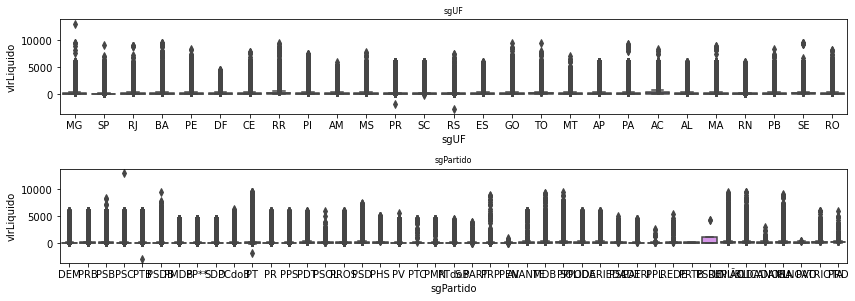

In [61]:
'''# Diagrama de Tukey (boxplot)
gridsize_boxplot = (4, 1)
fig_boxplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'vlrLiquido']

#positions = [dataset.groupby('sgPartido')['vlrLiquido']]

for i, positions in enumerate(positions):
    boxplot = plt.subplot2grid(gridsize_boxplot, (i, 0))
    boxplot.set_title(positions, fontsize=8)
    sns.boxplot(x=positions, data=dataset)

plt.tight_layout()
plt.show()
'''

# Diagrama de Tukey (boxplot)
gridsize_boxplot = (4, 1)
fig_boxplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido']  

for i, position in enumerate(positions):
    boxplot = plt.subplot2grid(gridsize_boxplot, (i, 0))
    boxplot.set_title(position, fontsize=8)
    sns.boxplot(x=position, y='vlrLiquido', data=dataset)

plt.tight_layout()
plt.show()


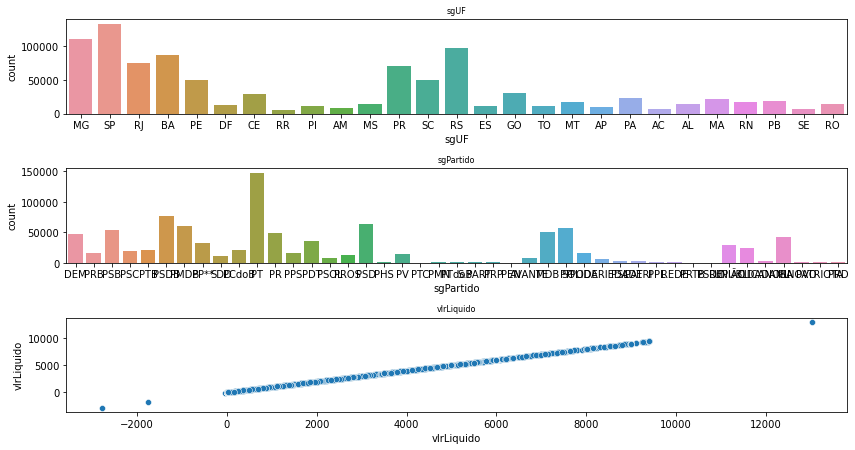

In [62]:
# Gráfico de dispersão
gridsize_scatter = (4, 1)
fig_scatter = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'vlrLiquido']

for i, position in enumerate(positions):
    scatterplot = plt.subplot2grid(gridsize_scatter, (i, 0))
    scatterplot.set_title(position, fontsize=8)
    
    if dataset[position].dtype == 'object':
        sns.countplot(x=position, data=dataset, ax=scatterplot)
    else:
        sns.scatterplot(x=position, y='vlrLiquido', data=dataset, ax=scatterplot)

plt.tight_layout()
plt.show()

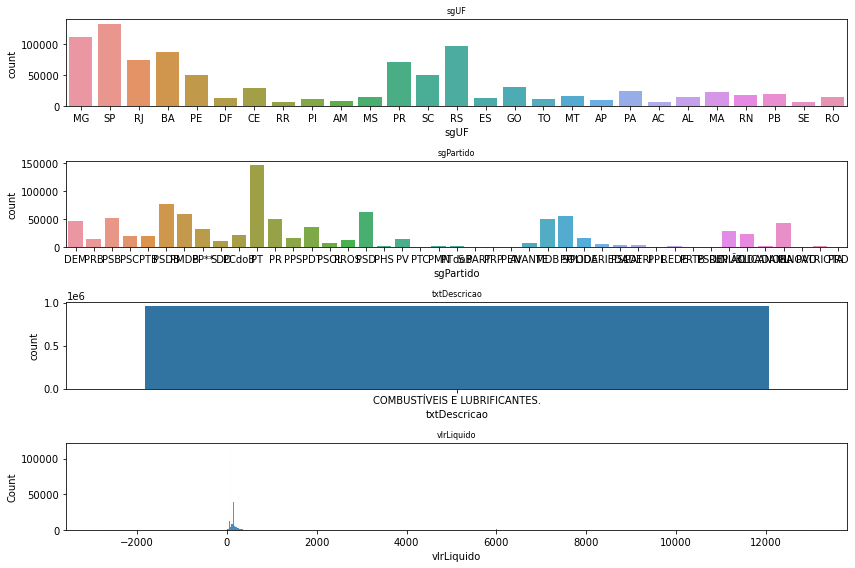

In [53]:
# Histograma
gridsize_barplot = (4, 1)
fig_barplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'txtDescricao', 'vlrLiquido']

for i, position in enumerate(positions):
    barplot = plt.subplot2grid(gridsize_barplot, (i, 0))
    barplot.set_title(position, fontsize=8)
    
    if dataset[position].dtype == 'object':
        sns.countplot(x=position, data=dataset, ax=barplot)
    else:
        sns.histplot(x=position, data=dataset, ax=barplot)

plt.tight_layout()
plt.show()

In [63]:
# Remover outliers - Winsorization

""" cols = list(dataset.columns)
cols.remove('col')

winsorization_flooring = 0.05
winsorization_capping = 1 - winsorization_flooring

not_selected_data_flooring = dataset[cols] <= dataset[cols].quantile(winsorization_flooring)
not_selected_data_capping = dataset[cols] >= dataset[cols].quantile(winsorization_capping)

not_selected_data_all = (not_selected_data_flooring & not_selected_data_capping)

data_index = dataset[cols][not_selected_data_all].index
dataset[cols].drop(data_index, inplace=True """

" cols = list(dataset.columns)\ncols.remove('col')\n\nwinsorization_flooring = 0.05\nwinsorization_capping = 1 - winsorization_flooring\n\nnot_selected_data_flooring = dataset[cols] <= dataset[cols].quantile(winsorization_flooring)\nnot_selected_data_capping = dataset[cols] >= dataset[cols].quantile(winsorization_capping)\n\nnot_selected_data_all = (not_selected_data_flooring & not_selected_data_capping)\n\ndata_index = dataset[cols][not_selected_data_all].index\ndataset[cols].drop(data_index, inplace=True "

Regressão Linear

In [64]:
dataset = dataset.loc[:,['datEmissao', 'vlrLiquido']]

In [65]:
# A regressão linear do sklearn não conseguiria usar diretamente a data então foi necessário converter
dataset['timestamp_unix'] = (dataset['datEmissao'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# Agora temos os segundos decorridos desde uma data base

In [66]:
#Parcionando dados
X = dataset[['timestamp_unix']]
y = dataset['vlrLiquido']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [67]:
# Criar modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [68]:
# Predição
predicted_values = model.predict(X_test)

In [69]:
# Análise da regressão
model.score(X_test,y_test)

0.0024945269591185593

<AxesSubplot:xlabel='datEmissao'>

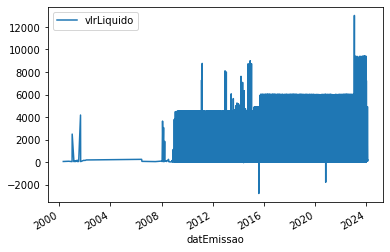

In [70]:
dataset.plot(y='vlrLiquido',x='datEmissao')

In [71]:
despesas_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4666978 entries, 0 to 4666977
Data columns (total 32 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   txNomeParlamentar          object 
 1   cpf                        float64
 2   ideCadastro                float64
 3   nuCarteiraParlamentar      float64
 4   nuLegislatura              int64  
 5   sgUF                       object 
 6   sgPartido                  object 
 7   codLegislatura             int64  
 8   numSubCota                 int64  
 9   txtDescricao               object 
 10  numEspecificacaoSubCota    int64  
 11  txtDescricaoEspecificacao  object 
 12  txtFornecedor              object 
 13  txtCNPJCPF                 object 
 14  txtNumero                  object 
 15  indTipoDocumento           int64  
 16  datEmissao                 object 
 17  vlrDocumento               float64
 18  vlrGlosa                   float64
 19  vlrLiquido                 float64
 20  nu

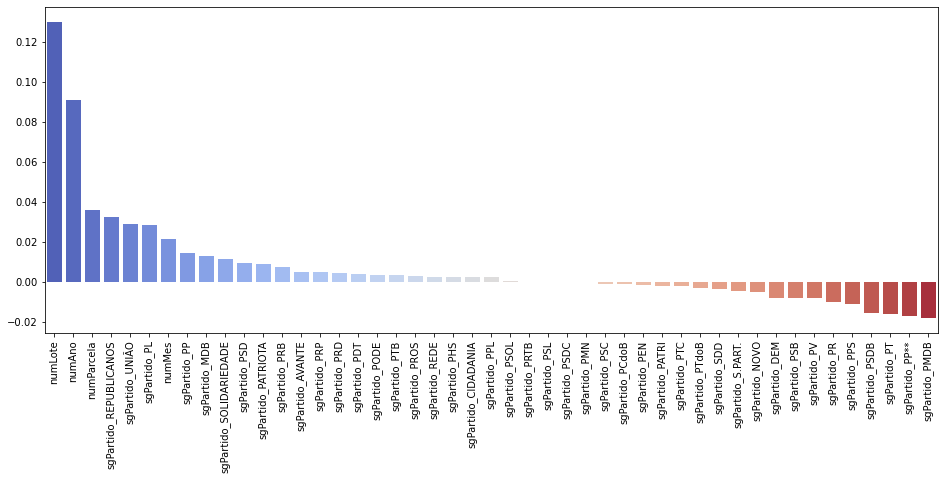

In [72]:
dummies = pd.get_dummies(despesas_completo[['numMes','sgPartido','numAno','numLote','vlrLiquido','numParcela']])
valores = dummies.corr()['vlrLiquido'].sort_values(ascending=False)[1:]

fig, ax = plt.subplots(figsize= (16, 6))
sns.barplot(x=valores.index, y=valores.values, palette='coolwarm')
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')

plt.show() # Não é possível encontrar relações lineares médias ou fortes ente valor líquido e as outras variáveis